#### Import required packages

In [1]:
# numeric and plotting libraries
import time
import os
import shutil
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from PIL import Image
import csv
import operator 
import pandas as pd 
# to create confusion metrics
import seaborn as sns
import scipy.io as sio
from cmath import nan
from cmath import isnan

In [2]:
from ipynb.fs.full.data_prep import *

In [3]:
%matplotlib inline

In [4]:
from sklearn.metrics import accuracy_score,confusion_matrix # metrics error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#### Data preparation

In [5]:
def ucitavanje_podataka(directory):
    id = 0
    data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        label = f.split("\\")[-1][0:2]
        id = id + 1
        dat = np.load(f)
        data.append([id, dat, label])
    
    #random.seed(2)
    random.shuffle(data)
    return data      

In [6]:
def vektorizacija(podaci):
    prevodjenje_labela = {"an": [1], "aw": [0]}  # TRUE:Mirtrons  FALSE:canonical microRN

    vektorizovani_podaci = []
    for a in podaci:
        vektorizovani_podaci.append([a[0], a[1], prevodjenje_labela[a[2]]])

    return vektorizovani_podaci

In [7]:
def podela_podataka(data_vectors):
    max = 0
    for i in range(0,len(data_vectors)):
        if(data_vectors[i][1].shape[0] > max):
            max = data_vectors[i][1].shape[0]

    X_train, y_train, X_test, y_test = np.empty([1, max, data_vectors[0][1].shape[1]]), [], np.empty([1, max, data_vectors[0][1].shape[1]]),[]
    i,j = 0,0

    random.shuffle(data_vectors)
    for item in data_vectors:
        if item[2]==[1]:
            i = i + 1
            if i <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant' , constant_values=0)
                X_test = np.append(X_test, np.array(item[1]).reshape(1, item[1].shape[0], np.array(item[1]).shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_train.append(item[2])
        else:
            j = j + 1
            if  j <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_test = np.append(X_test, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_train.append(item[2])
    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    X_test = np.array(X_test[1:])
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [18]:
def podela_podataka_tren(data_vectors):
    max = 0
    for i in range(0,len(data_vectors)):
        if(data_vectors[i][1].shape[0] > max):
            max = data_vectors[i][1].shape[0]

    X_train, y_train = np.empty([1, max, data_vectors[0][1].shape[1]]), []

    random.shuffle(data_vectors)

    for item in data_vectors:
        if(item[1].shape[0] < max):
            item[1] = np.pad(item[1], [(0, max-item[1].shape[0]), (0, 0)], mode='constant')      
        X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
        y_train.append(item[2])
        #y_train.append(random.choice([[0], [1]]))
    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    
    return X_train, y_train

#### Test/Train

In [9]:
putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
#niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
podaci = ucitavanje_podataka(putanja)
vektorizovani_podaci = vektorizacija(podaci)

X_train, y_train, X_test, y_test = podela_podataka(vektorizovani_podaci)
X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=object)
y_test = np.array(y_test)

In [10]:
X_tr = []
for i in X_train:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_tr.append(temp)
X_train = np.array(X_tr, dtype=object)

X_ts = []
for i in X_test:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_ts.append(temp) 
X_test = np.array(X_ts, dtype=object)

### KNN

In [11]:
knn = OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train,y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [12]:
predictions = knn.predict(X_test)

In [13]:
print('KNN Accuracy: %.3f' % accuracy_score(y_test,predictions))

KNN Accuracy: 1.000


Text(0.5, 1.0, 'Accuracy Score: 1.0')

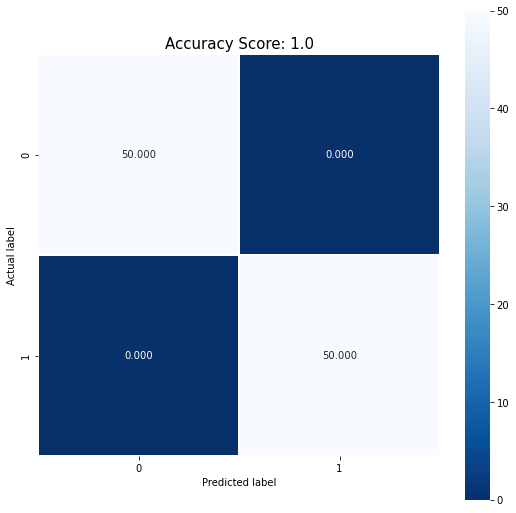

In [14]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title,size=15)

### Random Forest

In [15]:
def RF(X_train, y_train, X_test, y_test):
    forest = RandomForestClassifier(criterion='gini',
                                    n_estimators=5,
                                    random_state=1,
                                    n_jobs=2)

    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    
    return y_pred

In [16]:
def mat_of_conf(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
    plt.title(all_sample_title,size=15)
    plt.show()

<ipython-input-15-ee0a87f07aed>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


Accuracy: 0.990


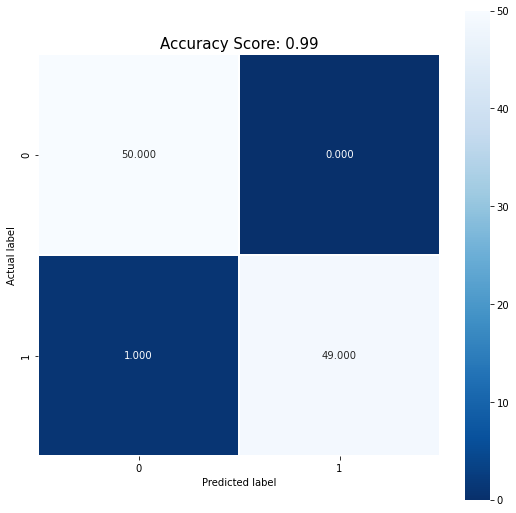

In [17]:
Forest = RF(X_train, y_train, X_test, y_test)
mat_of_conf(y_test,Forest)

##### Iterating over different regions

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from cmath import isnan

putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()

for br1 in range(1,13):
    for br2 in range(1,13):
        if(br1!=br2):
            print("Trained on region " + str(br1) + ", and tested on region " + str(br2))

            mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()
            data_per_trial(1, mat_load, roi_load, ind_load, list1, list2, list3, list4)

            putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
            #niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
            podaci = ucitavanje_podataka(putanja)
            vektorizovani_podaci = vektorizacija(podaci)

            X_train, y_train, X_test, y_test = podela_podataka(vektorizovani_podaci)
            X_train = np.array(X_train, dtype=object)
            y_train = np.array(y_train)
            X_test = np.array(X_test, dtype=object)
            y_test = np.array(y_test)

            X_tr = []
            for i in X_train:
                temp = []
                for j in i:
                    for k in j:
                        if(isnan(k)):
                            k = 0
                        temp.append(k)
                X_tr.append(temp)
            X_train = np.array(X_tr, dtype=object)

            X_ts = []
            for i in X_test:
                temp = []
                for j in i:
                    for k in j:
                        if(isnan(k)):
                            k = 0
                        temp.append(k)
                X_ts.append(temp) 
            X_test = np.array(X_ts, dtype=object)

            Forest = RF(X_train, y_train, X_test, y_test)
            mat_of_conf(y_test,Forest)

##### Iterating over different sessions

In [ ]:
import warnings
warnings.filterwarnings('ignore')

putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()

tr = 1

for br1 in range(0, 4):
    for br2 in range(0, 4):
        if(br1 != br2):
            print("(Trial " + str(tr) + ") Trained on session " + str(br1+1) + ", and tested on session " + str(br2+1))
           
            data_per_ses(tr, br1, mat_load, roi_load, ind_load, list1, list2, list3, list4)
            podaci = ucitavanje_podataka(putanja)
            vektorizovani_podaci = vektorizacija(podaci)
            X_train_, y_train_ = podela_podataka_tren(vektorizovani_podaci)
            X_tr = []
            for i in X_train_:
                temp = []
                for j in i:
                    for k in j:
                        temp.append(k)
                X_tr.append(temp)
            X_train_ = np.nan_to_num(X_tr)

            data_per_ses(tr, br2, mat_load, roi_load, ind_load, list1, list2, list3, list4)
            podaci = ucitavanje_podataka(putanja)
            vektorizovani_podaci = vektorizacija(podaci)
            X_test_, y_test_ = podela_podataka_tren(vektorizovani_podaci)
            X_ts = []
            for i in X_test_:
                temp = []
                for j in i:
                    for k in j:
                        temp.append(k)
                X_ts.append(temp) 
            X_test_ = np.nan_to_num(X_ts)

            Forest = RF(X_train_, y_train_, X_test_, y_test_)
            mat_of_conf(y_test_,Forest)